# 1. Model and data

Let us pick a fixed model and a fixed text dataset

## 1.1. Model

In [ ]:
#!conda install -c conda-forge gensim --yes

In [5]:
import gensim
import gensim.downloader
vectorizer = gensim.downloader.load('glove-wiki-gigaword-100')

## 1.2. Data

In [ ]:
#!wget -O text_data https://github.com/DinarZayahov/thesaurus/raw/master/data/2020

In [6]:
import pickle
texts = pickle.load(open("text_data", 'rb'))

In [41]:
from nltk.corpus import stopwords
swords = set(stopwords.words('english'))

def take(word):
    if word in swords: return False
    if '|' in word or 'ˆ' in word: return False
    if word[-1] == '-': return False
    if word[0] == '-': return False
    if word[0] == '/': return False
    if word[-1] == '−': return False
    if '±' in word: return False
    if '¯' in word: return False
    if len(word) < 2: return False
    return True

In [44]:
from tqdm import tqdm

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from collections import Counter

swords = set(stopwords.words('english'))
swords = swords.union({'.', ',', '-', ';', ':', '', '···', '..'})

unseen = Counter()
seen_vectors = {}
unseen_contexts = {}

width = 2

for text in tqdm(texts):
    sents = sent_tokenize(text['clean'])
    for sent in sents:
        sentence = [word.lower() for word in word_tokenize(sent) if take(word)]
        for i, word in enumerate(sentence):
            if (word in vectorizer) and (word not in seen_vectors):
                seen_vectors[word] = vectorizer[word]
            elif (word not in vectorizer):
                unseen[word] += 1
                if word not in unseen_contexts:
                    unseen_contexts[word] = []
                unseen_contexts[word].append(list(sentence[max(0, i - width):(i + width + 1)]))

100%|██████████| 397/397 [00:24<00:00, 16.10it/s]


In [74]:
unseen.most_common(20)

[('µm', 1295),
 ('∆t', 399),
 ('edr3', 336),
 ('iv−v', 265),
 ('two-qubit', 261),
 ('metasurface', 248),
 ('psz1', 198),
 ('on-sky', 181),
 ('lamost', 180),
 ('metasurfaces', 179),
 ('srcreu', 171),
 ('optomechanical', 170),
 ('wdh', 168),
 ('bl4130', 156),
 ('fidelities', 151),
 ('schr¨odinger', 148),
 ('pygsti', 147),
 ('pentacene', 143),
 ('microbubble', 135),
 ('iii−iv', 132)]

## 2. Collect dataset

Given the text we will collect the dataset of 5-word contexts, 4 context word will predict inner word. Predictor model is linear transform. Method in OLS. Metric to check are L2 and COS. We will exclude stop-word before training.

We will consider 2 setups: order-independent context (average vector) and order dependent (concatenated vector).

In [62]:
cache = {}

def cached_emb(word):
    global cache
    if word not in cache:
        if word in vectorizer:
            cache[word] = vectorizer[word]
        else:
            cache[word] = None
    return cache[word]

dataset_full = []
dataset_avg = []
target = []

import numpy as np

for text in tqdm(texts):
    sents = sent_tokenize(text['clean'])
    for sent in sents:
        sentence = [word.lower() for word in word_tokenize(sent) if take(word)]
        L = len(sentence)
        for i in range(width, L - width):
            rr = sentence[i - width:i + width + 1]
        vcs = [cached_emb(word) for word in rr if cached_emb(word) is not None]
        if len(vcs) == 2 * width + 1:
            dataset_full.append(np.hstack(vcs[:width] + vcs[width+1:]))
            dataset_avg.append(np.vstack(vcs[:width] + vcs[width+1:]).mean(axis=0))
            target.append(vcs[width])
            
dataset_full = np.array(dataset_full)
dataset_avg = np.array(dataset_avg)
target = np.array(target)

100%|██████████| 397/397 [00:26<00:00, 15.18it/s]


In [63]:
dataset_full.shape, dataset_avg.shape, target.shape

((96597, 400), (96597, 100), (96597, 100))

In [98]:
from random import shuffle
idxs = list(range(len(dataset_full)))
shuffle(idxs)

N = int(len(idxs) * .8)
train_idx, test_idx = idxs[:N], idxs[N:]


train_full, test_full = dataset_full[train_idx], dataset_full[test_idx]
train_avg, test_avg = dataset_avg[train_idx], dataset_avg[test_idx]
train_target, test_target = target[train_idx], target[test_idx]

# 3. Train a simple linear model!

We will have 100 x 100 = 10000 or 400 x 100 = 40000 trainable parameters. The amount of input should be enough.

In [95]:
F_full = (np.matrix(train_full.T @ train_full)).I @ train_full.T @ train_target
F_avg = (np.matrix(train_avg.T @ train_avg)).I @ train_avg.T @ train_target

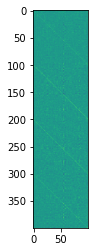

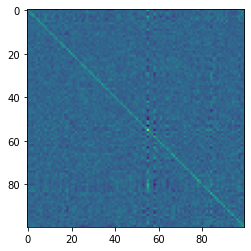

In [103]:
import matplotlib.pyplot as plt

plt.imshow(F_full)
plt.show()

plt.imshow(F_avg)
plt.show()

In [104]:
predict_full = test_full @ F_full
predict_avg = test_avg @ F_avg

In [107]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

cos_f, cos_a, euc_f, euc_a = [], [], [], []

for i in tqdm(range(len(test_target))):
    cos_full = cosine_similarity([test_target[i]], predict_full[i])[0, 0]
    cos_avg = cosine_similarity([test_target[i]], predict_avg[i])[0, 0]
    euc_full = euclidean_distances([test_target[i]], predict_full[i])[0, 0]
    euc_avg = euclidean_distances([test_target[i]], predict_avg[i])[0, 0]
    
    cos_f.append(cos_full)
    cos_a.append(cos_avg)
    euc_f.append(euc_full)
    euc_a.append(euc_avg)

100%|██████████| 19320/19320 [00:06<00:00, 2799.20it/s]


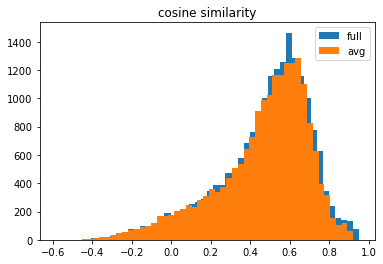

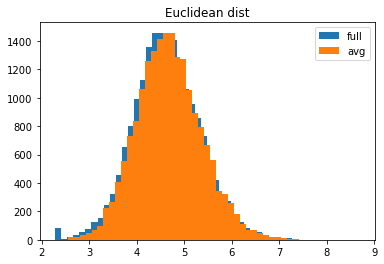

In [113]:
import matplotlib.pyplot as plt

plt.hist(cos_f, bins=50, label="full")
plt.hist(cos_a, bins=50, label="avg")
plt.title("cosine similarity")
plt.legend()
plt.show()

plt.hist(euc_f, bins=50, label="full")
plt.hist(euc_a, bins=50, label="avg")
plt.title("Euclidean dist")
plt.legend()
plt.show()

# 4. Simple 2-layered perceptron?

In [126]:
from sklearn.neural_network import MLPRegressor
ann_full = MLPRegressor(
                hidden_layer_sizes=(100,), 
                activation='logistic',
                random_state=77,
                verbose=True).fit(train_full, train_target)
ann_avg = MLPRegressor(
                hidden_layer_sizes=(100,), 
                activation='logistic',
                random_state=77,
                verbose=True).fit(train_avg, train_target)

Iteration 1, loss = 0.11339785
Iteration 2, loss = 0.11008431
Iteration 3, loss = 0.10924811
Iteration 4, loss = 0.10869340
Iteration 5, loss = 0.10827432
Iteration 6, loss = 0.10792225
Iteration 7, loss = 0.10759321
Iteration 8, loss = 0.10727470
Iteration 9, loss = 0.10698763
Iteration 10, loss = 0.10669008
Iteration 11, loss = 0.10641986
Iteration 12, loss = 0.10611972
Iteration 13, loss = 0.10585258
Iteration 14, loss = 0.10556212
Iteration 15, loss = 0.10528147
Iteration 16, loss = 0.10501622
Iteration 17, loss = 0.10476579
Iteration 18, loss = 0.10450211
Iteration 19, loss = 0.10427481
Iteration 20, loss = 0.10403184
Iteration 21, loss = 0.10381098
Iteration 22, loss = 0.10361026
Iteration 23, loss = 0.10339328
Iteration 24, loss = 0.10319573
Iteration 25, loss = 0.10300675
Iteration 26, loss = 0.10281642
Iteration 27, loss = 0.10264413
Iteration 28, loss = 0.10247273
Iteration 29, loss = 0.10231963
Iteration 30, loss = 0.10214864
Iteration 31, loss = 0.10201009
Iteration 32, los

In [130]:
predict_full = ann_full.predict(test_full)
predict_avg = ann_avg.predict(test_avg)
predict_full.shape

(19320, 100)

100%|██████████| 19320/19320 [00:06<00:00, 3051.63it/s]


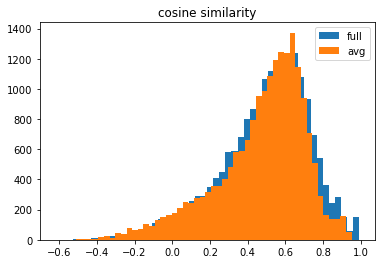

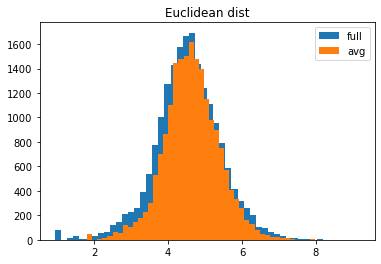

In [133]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

cos_f, cos_a, euc_f, euc_a = [], [], [], []

for i in tqdm(range(len(test_target))):
    # print(test_target[i].shape, predict_full[i].shape)
    cos_full = cosine_similarity([test_target[i]], [predict_full[i]])[0, 0]
    cos_avg = cosine_similarity([test_target[i]], [predict_avg[i]])[0, 0]
    euc_full = euclidean_distances([test_target[i]], [predict_full[i]])[0, 0]
    euc_avg = euclidean_distances([test_target[i]], [predict_avg[i]])[0, 0]
    
    cos_f.append(cos_full)
    cos_a.append(cos_avg)
    euc_f.append(euc_full)
    euc_a.append(euc_avg)
    
import matplotlib.pyplot as plt

plt.hist(cos_f, bins=50, label="full")
plt.hist(cos_a, bins=50, label="avg")
plt.title("cosine similarity")
plt.legend()
plt.show()

plt.hist(euc_f, bins=50, label="full")
plt.hist(euc_a, bins=50, label="avg")
plt.title("Euclidean dist")
plt.legend()
plt.show()

# 5. Multilinear!

In [169]:
from sklearn.cluster import KMeans

n_clusters = 50

# knn_full = KMeans(n_clusters=100, random_state=77).fit(train_full)
knn_avg = KMeans(n_clusters=n_clusters, random_state=77).fit(train_avg)
clustered_avg = knn_avg.predict(train_avg)

In [170]:
models = []

for i in range(n_clusters):
    X = train_avg[clustered_avg == i]
    Y = train_target[clustered_avg == i]
    F_avg = (np.matrix(X.T @ X)).I @ X.T @ Y
    models.append(F_avg)

In [171]:
clustered_test = knn_avg.predict(test_avg)

predict_avg = []

for i in range(len(test_avg)):
    model = models[clustered_test[i]]
    predict_avg.append((test_avg[i] @ model))

predict_avg = np.array(pred).reshape(-1, 100)
predict_avg.shape

(19320, 100)

100%|██████████| 19320/19320 [00:03<00:00, 5890.55it/s]


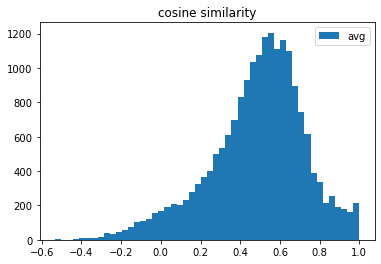

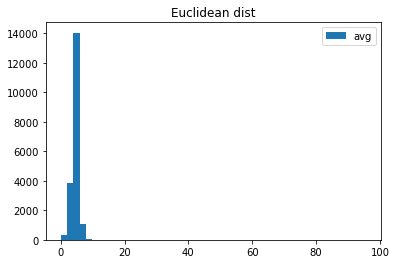

In [172]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

cos_f, cos_a, euc_f, euc_a = [], [], [], []

for i in tqdm(range(len(test_target))):
    cos_avg = cosine_similarity([test_target[i]], [predict_avg[i]])[0, 0]
    euc_avg = euclidean_distances([test_target[i]], [predict_avg[i]])[0, 0]
    
    cos_a.append(cos_avg)
    euc_a.append(euc_avg)
    
import matplotlib.pyplot as plt

plt.hist(cos_a, bins=50, label="avg")
plt.title("cosine similarity")
plt.legend()
plt.show()

plt.hist(euc_a, bins=50, label="avg")
plt.title("Euclidean dist")
plt.legend()
plt.show()

In [209]:
for key in unseen_contexts:
    print(key)
    q = []
    for c in unseen_contexts[key]:
        r = []
        for w in c:
            e = cached_emb(w)
            if e is not None:
                r.append(cached_emb(w))

        if r:
            v = np.vstack(r).mean(axis=0)
            clust = knn_avg.predict(np.array([v]))[0]
            prediction = (v @ models[clust]).A1
            q.append(vectorizer.most_similar(prediction)[0])
    if q:
        q.sort(key=lambda t: -t[1])
        print("\t", *q[:3])

cc-by-nc-nd
	 ('same', 0.8427301645278931)
foteinopoulou∗
	 ('answers', 0.4834132492542267)
cemps
	 ('institute', 0.7262021899223328)
metallic-based
	 ('similar', 0.7566207051277161)
s.foteinopoulou
	 ('same', 0.7916461825370789)
exeter.ac.uk
	 ('defined', 0.7471535205841064) ('however', 0.719349205493927)
meta-structures
	 ('types', 0.7597655653953552)
extra-ordinary
	 ('rather', 0.8363257646560669) ('change', 0.8300967812538147) ('thus', 0.8068104386329651)
ultra-refraction
	 ('example', 0.7978460788726807)
superprism
	 ('particular', 0.7156153917312622)
fringent
	 ('change', 0.7514517903327942)
sub-wavelength
	 ('same', 0.8375896215438843) ('same', 0.8297698497772217) ('same', 0.8279590010643005)
quasi-crystal
	 ('well', 0.8701122403144836)
essarily
	 ('data', 0.6132526993751526)
meta-atom
	 ('same', 0.8611078858375549) ('these', 0.8585971593856812) ('well', 0.8518322110176086)
wavenormals
	 ('similar', 0.7892500162124634) ('similar', 0.7573378086090088) ('structure', 0.707729160785

KeyboardInterrupt: 